# Machine Learning with The Titanic Dataset
by pou426 (github.com/pou426)

In [538]:
import pandas as pd
import numpy as np

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [539]:
train_df = pd.read_csv('input/train.csv')
train_df_before_cleaning = train_df.copy()
test_df = pd.read_csv('input/test.csv')
combine_df = [train_df, test_df]

## 1. Describe data

Features in dataset: https://www.kaggle.com/c/titanic/data

The data has been split into a training set and a testing set.

#### Data Dictionary
|Variable|Definition|Key|
|--------|----------|---|
|survival|Survival  |0 = No, 1 = Yes|
|pclass  |Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex     |Sex|   |
|Age     |Age in years|  |
|sibsp   |# of siblings / spouses aboard the Titanic|  |
|parch   |# of parents / children aboard the Titanic|  |
|ticket  |Ticket number|  |
|fare    |Passenger fare|  |
|cabin   |Cabin number|  |
|embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|

#### Variable notes

<b>pclass</b>: A proxy for socio-economic status (SES)

|pclass|SES|
|------|---|
|1st|Upper|
|2nd|Middle|
|3rd|Lower|

<b>age</b>: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

<b>sibsp</b>: The dataset defines family relations in this way...

Sibling = brother, sister, stepbrother, stepsister<br>
Spouse = husband, wife (mistresses and fiancés were ignored)

<b>parch</b>: The dataset defines family relations in this way...

Parent = mother, father<br>
Child = daughter, son, stepdaughter, stepson<br>
Some children travelled only with a nanny, therefore parch=0 for them.

In [540]:
print('training set shape: '+str(train_df.shape))
print('testing set shape: '+str(test_df.shape))
train_df.describe()
# missing data in Age 

training set shape: (891, 12)
testing set shape: (418, 11)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [541]:
train_df.describe(include=['O']) 
# two missing values in embarked

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Graham, Mr. George Edward",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


In [542]:
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [543]:
test_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Rosenbaum, Miss. Edith Louise",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


In [544]:
# inspect the data
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 1.1 Pivoting features

In [545]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

pclass_df = train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)
sex_df = train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)
sibsp_df = train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)
parch_df = train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)
display_side_by_side(pclass_df, sex_df, sibsp_df, parch_df)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363
,Sex,Survived
0,female,0.742038
1,male,0.188908
,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395


In [546]:
print 'The number of samples for each number of Parch:'
temp = train_df.Parch.value_counts()
for i, t in enumerate(temp):
    print 'number of samples = {}, number of Parch = {}'.format(i, t)

The number of samples for each number of Parch:
number of samples = 0, number of Parch = 678
number of samples = 1, number of Parch = 118
number of samples = 2, number of Parch = 80
number of samples = 3, number of Parch = 5
number of samples = 4, number of Parch = 5
number of samples = 5, number of Parch = 4
number of samples = 6, number of Parch = 1


Pclass, Sex and SibSp all exhibition some kind of correlation while there is none in Parch. The number of samples we have for Parch > 5 is too small and thus not representative.

## 2. Feature Engineering 
### 2.1 Feature Engineering with SibSp and Parch
To combine SibSp and Parch into a new variable FamilySize

In [547]:
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [548]:
train_df[['FamilySize','Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived',ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [549]:
print 'The number of samples for each number of FamilySize:'
fam_temp = train_df.FamilySize.value_counts()
for i, t in enumerate(fam_temp):
    print 'number of samples = {}, number of FamilySize = {}'.format(i, t)

The number of samples for each number of FamilySize:
number of samples = 0, number of FamilySize = 537
number of samples = 1, number of FamilySize = 161
number of samples = 2, number of FamilySize = 102
number of samples = 3, number of FamilySize = 29
number of samples = 4, number of FamilySize = 22
number of samples = 5, number of FamilySize = 15
number of samples = 6, number of FamilySize = 12
number of samples = 7, number of FamilySize = 7
number of samples = 8, number of FamilySize = 6


<div style="color:red">Is the difference between the number of samples for different FamilySize's too big?</div>

### 2.2 Feature Engineering with Name
Convert Name to Title, grouped by type.

In [550]:
for dataset in combine_df:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [551]:
for dataset in combine_df:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [552]:
print 'The number of samples for each Title:'
title_temp = train_df.Title.value_counts()
for i, t in enumerate(title_temp):
    print 'number of samples = {}, Title = {}'.format(i, t)

The number of samples for each Title:
number of samples = 0, Title = 517
number of samples = 1, Title = 185
number of samples = 2, Title = 126
number of samples = 3, Title = 40
number of samples = 4, Title = 23


### 2.3 Drop Unnecessary Columns

In [553]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

In [554]:
train_df = train_df.drop(['SibSp', 'Parch'], axis=1)
test_df = test_df.drop(['SibSp', 'Parch'], axis=1)

In [555]:
# Too little data points from Cabin (~140)
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)
combine_df = [train_df, test_df]

In [556]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

In [557]:
train_df.head(5)

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title
0,0,3,male,22.0,7.2500,S,2,Mr
1,1,1,female,38.0,71.2833,C,2,Mrs
2,1,3,female,26.0,7.9250,S,1,Miss
3,1,1,female,35.0,53.1000,S,2,Mrs
4,0,3,male,35.0,8.0500,S,1,Mr


## 3. Missing Data Imputation
Given the small size of the dataset, we should not opt for deleting either entire observations or variables containing missing values. We could either replace missing values with a sensible value given the distribution of the data (e.g. mean, median or mode) or we could go with prediction.

### 3.1 Embarked

In [558]:
# Option 1 - use median:
# Only two missing values in Embarked, fill them in with median = "S"
train_df['Embarked'] = train_df['Embarked'].fillna('S')

# Option 2 - infer from other variables

### 3.2 Fare

In [559]:
# for test_df, there is one missing value
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)

### 3.3 Age
There are some missing data in the Age column, is Regression possible? To do prediction in regression we would need some explanatory variable(s). To find these varaibles we examine any correlation between Age and other features... But let's assume there isn't any feature that could predict Age, so we generate random values based on Age's distribution.

In [560]:
# train_df['Age'].plot(kind='hist', xlim=(0,100), bins=20)
print 'There are ' + str(train_df.Age.count()) + ' age values'

There are 714 age values


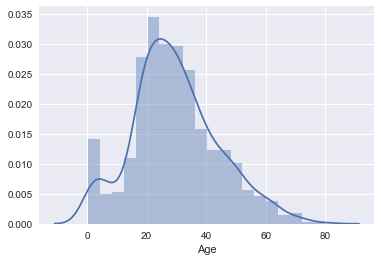

In [561]:
fig, ax = plt.subplots()
sns.distplot(train_df.Age.dropna(), ax=ax)
fig.show()

Take whatever other features are available and populated and build a model using the examples that do have values for the variable in question, then predict the value for the others. 
Populate the missing Age variable using a RandomForestClassifier model:

In [562]:
train_df_before_age = train_df.copy()
train_df_before_age.head(5) # create a copy before populating Age column

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title
0,0,3,male,22.0,7.2500,S,2,Mr
1,1,1,female,38.0,71.2833,C,2,Mrs
2,1,3,female,26.0,7.9250,S,1,Miss
3,1,1,female,35.0,53.1000,S,2,Mrs
4,0,3,male,35.0,8.0500,S,1,Mr


#### Note: Convert categorical data to numeric data before we use random forest to generate missing age values.

In [563]:
combine_df = [train_df, test_df] 

In [564]:
# # convert into numerical
# title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
# for dataset in combine_df:
#     dataset['Title'] = dataset['Title'].map(title_mapping)
#     dataset['Title'] = dataset['Title'].fillna(0)

# train_df.head(5)

# convert categorical to numerical
for dataset in combine_df:    
    dataset['Title'] = dataset['Title'].map( {'Mr':0, 'Miss':1, 'Mrs':2, 'Master':4, 'Rare':5} ).astype(int)
    dataset['Title'] = dataset['Title'].fillna(0)

In [565]:
# convert categorical to numerical
for dataset in combine_df:
    dataset['Embarked'] = dataset['Embarked'].map( {'S':0, 'C':1, 'Q':2} ).astype(int)
    
train_df.head(5)

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title
0,0,3,male,22.0,7.2500,0,2,0
1,1,1,female,38.0,71.2833,1,2,2
2,1,3,female,26.0,7.9250,0,1,1
3,1,1,female,35.0,53.1000,0,2,2
4,0,3,male,35.0,8.0500,0,1,0


In [566]:
# convert categorical to numerical
for dataset in combine_df:
    dataset['Sex'] = dataset['Sex'].map( {'male':0, 'female':1} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title
0,0,3,0,22.0,7.2500,0,2,0
1,1,1,1,38.0,71.2833,1,2,2
2,1,3,1,26.0,7.9250,0,1,1
3,1,1,1,35.0,53.1000,0,2,2
4,0,3,0,35.0,8.0500,0,1,0


#### Now use Random Forest with mapped data:

In [567]:
# Option 1
# Populate missing ages using RandomForestClassifier
def setMissingAges(df):
    age_df = df[['Age','Pclass','Sex','Fare','Embarked','FamilySize', 'Title']]
    knownAge = age_df.loc[ (df.Age.notnull()) ]
    unknownAge = age_df.loc[ (df.Age.isnull()) ]
    # store all age values in a target array
    y = knownAge.values[:, 0]
    # store all other values in the feature array
    X = knownAge.values[:, 1::]
    # create and fit a model
    rtr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
    rtr.fit(X,y)
    # predict missing age values using the fitted model
    pred_ages = rtr.predict(unknownAge.values[:, 1::])
    # assign predictions to the full dataset
    df.loc[ (df.Age.isnull()), 'Age'] = pred_ages

setMissingAges(train_df)
setMissingAges(test_df)

In [568]:
# # Option 2
# # Another way is to generate random value using mean and standard deviation
# # get average, std, and number of NaN values in titanic_df
# average_age_df   = train_df["Age"].mean()
# std_age_df       = train_df["Age"].std()
# count_nan_age_df = train_df["Age"].isnull().sum()

# # get average, std, and number of NaN values in test_df
# average_age_test   = test_df["Age"].mean()
# std_age_test       = test_df["Age"].std()
# count_nan_age_test = test_df["Age"].isnull().sum()

# # generate random numbers between (mean - std) & (mean + std)
# rand_1 = np.random.randint(average_age_df - std_age_df, average_age_df + std_age_df, size = count_nan_age_df)
# rand_2 = np.random.randint(average_age_test - std_age_test, average_age_test + std_age_test, size = count_nan_age_test)

# # fill NaN values in Age column with random values generated
# train_df["Age"][np.isnan(train_df["Age"])] = rand_1
# test_df["Age"][np.isnan(test_df["Age"])] = rand_2

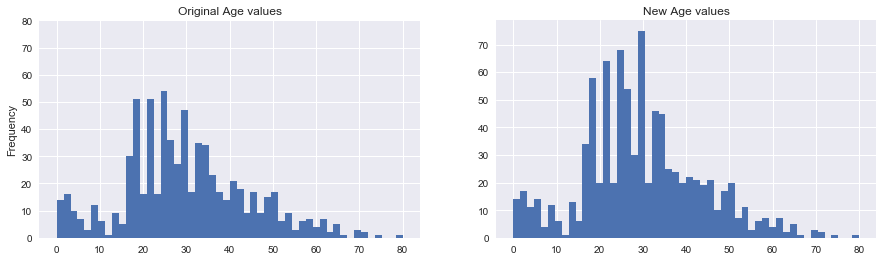

In [569]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,4))
ax1.set_title('Original Age values')
ax2.set_title('New Age values')
y_max = max(train_df['Age'].max(), train_df_before_age['Age'].max())
train_df_before_age['Age'].dropna().astype(int).plot.hist(bins=50, ax=ax1, ylim=(0,y_max))
train_df['Age'].astype(int).hist(bins=50, ax=ax2)

## 4. Visualisation
Here we plot pretty (and perhaps interactive) graphs and charts to visualise our titanic dataset

In [570]:
train_df.head(5)

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title
0,0,3,0,22.0,7.2500,0,2,0
1,1,1,1,38.0,71.2833,1,2,2
2,1,3,1,26.0,7.9250,0,1,1
3,1,1,1,35.0,53.1000,0,2,2
4,0,3,0,35.0,8.0500,0,1,0


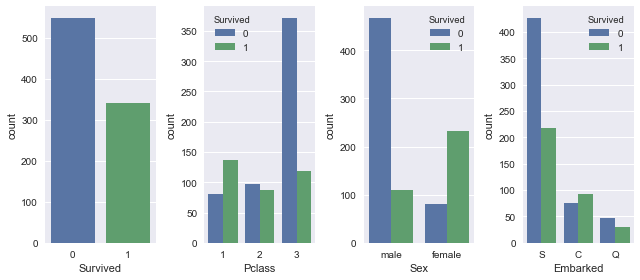

In [571]:
f, axes = plt.subplots(1, 4, figsize=(9, 4), sharey=False)
g=sns.factorplot("Survived",data=train_df_before_cleaning,kind="count",ax=axes[0]) # should use a dictionary to map the x axis instead but i am lazy
plt.close(g.fig)
g=sns.factorplot("Pclass",data=train_df_before_cleaning,kind="count",hue="Survived",ax=axes[1])
plt.close(g.fig)
g=sns.factorplot("Sex",data=train_df_before_cleaning,kind="count",hue="Survived",ax=axes[2])
plt.close(g.fig)
g=sns.factorplot("Embarked",data=train_df_before_cleaning,kind="count",hue="Survived",ax=axes[3])
plt.close(g.fig)
plt.tight_layout()
plt.show()

In [572]:
total = train_df.shape[0]
survival_pclass_ratio = np.zeros((2,3))

for i in {1,2,3}:
    for j in {0,1}:
        value = train_df[(train_df.Pclass==i) & (train_df.Survived==j)].shape[0]
        ratio = value/float(total)
        survival_pclass_ratio[j,i-1] = ratio

survival_pclass_ratio_df = pd.DataFrame(survival_pclass_ratio, columns=['1st','2nd','3rd'])

print 'The ratio of survival for different Pclass:'
survival_pclass_ratio_df.head(2)

The ratio of survival for different Pclass:


,1st,2nd,3rd
0,0.089787,0.108866,0.417508
1,0.152637,0.097643,0.133558


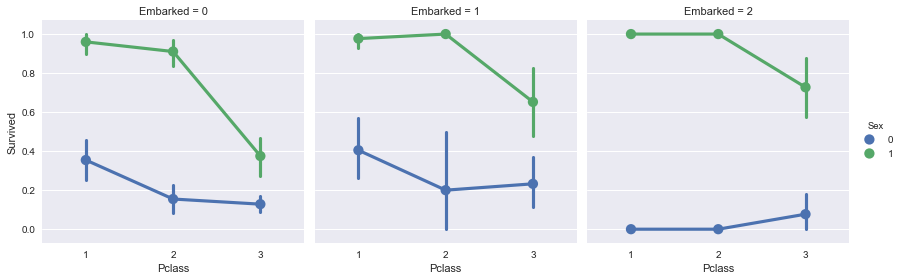

In [573]:
g = sns.factorplot(x="Pclass", y="Survived", data=train_df, hue="Sex", col="Embarked")

In [574]:
# how many 1st class in embarked=Q?
train_df.head(5)

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title
0,0,3,0,22.0,7.2500,0,2,0
1,1,1,1,38.0,71.2833,1,2,2
2,1,3,1,26.0,7.9250,0,1,1
3,1,1,1,35.0,53.1000,0,2,2
4,0,3,0,35.0,8.0500,0,1,0


## 5. Model, Predict and Solve

In [575]:
test_df.head(5)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title
0,892,3,0,34.5,7.8292,2,1,0
1,893,3,1,47.0,7.0000,0,2,2
2,894,2,0,62.0,9.6875,2,1,0
3,895,3,0,27.0,8.6625,0,1,0
4,896,3,1,22.0,12.2875,0,3,2


In [576]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test = test_df.drop("PassengerId", axis=1).copy()
print "X_train.shape = {}, Y_train.shape = {}, X_test.shape = {}".format(X_train.shape, Y_train.shape, X_test.shape)

X_train.shape = (891, 7), Y_train.shape = (891,), X_test.shape = (418, 7)


### Logistic Regression

Logistic Regression measures the relationship between the categorical dependent variable (feature) and one or more independent variables (features) by estimating probabilities using a logistic function, which is the cumulative logistic distributino.

In [577]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train)*100, 2)
print "accuracy score = ", acc_log

accuracy score =  81.14


To validate our assumptions and decisions for feature creating and completing goals by calculation the coefficient of the features in the decision function.

Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrese the log-odds of the response (and thus decrease the probability).

In [578]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df['Correlation'] = pd.Series(logreg.coef_[0])
coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.325233
6,Title,0.397884
4,Embarked,0.188540
3,Fare,0.004607
2,Age,-0.033524
5,FamilySize,-0.325149
0,Pclass,-0.943483


* Sex is the highest positive coefficient, implying as the Sex value increases (male: 0 to female: 1), the probabiliy of Survived=1 increases the most.
* Invesrsely as Pclass increase, probability of Survived=1 decreases the most.
* Age*Class is a good artiticial feature to model as it has the second highest negative correlation with Survived.
* So is Title as second highest positive correlation.

### Support Vector Machines

supervised learning models with associated learning algorithm that analyse data used for classification and regression analysis. Given a set of training samples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new test samples to one category or the other, making it a non-probabilistic binary linear classifier.

In [581]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

92.37

### K-Nearest Neighbours
a non-parametric method used for classification and regression. A sample is classified by a majority vote of its neighbours, with the sample being assigned to the class most common among its k nearest neighbours (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbour.

In [583]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train)*100, 2)
acc_knn

85.97

### Naive Bayes Classifier

a family of simple probabilistic classifiers based on applying Bayes' theorem with strong (naive) independence assumptions between the features. Naive Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features) in a learning problem.

In [585]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train)*100, 2)
acc_gaussian

80.58

### Perceptron

an algorithm for supervised learning of binary classifiers (functions that can decide whether an input, represented by a vector of numbers, belongs to some specific class or not). It is a type of linear classifier, i.e. a classification algorithm that makes its predictions based on a linear predictor function combining a set of weights with the feature vector. The algorithm allows for online learning, in that it processes elements in the training set one at a time.

In [587]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

67.0

### Linear SVC

In [589]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

77.1

### Stochastic Gradient Descent

In [591]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

54.77

### Decision tree

maps features (tree branches) to conclusions about the target value (tree leaves). Tree models where the target variable can take a finite set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees.